# **Introduction**

In this tutorial, we demonstrate how to use autoencoer (AE) on Mouse hematopoietic  dataset. The mouse hematopoietic dataset is time-series scRNA-seq datasewas downloaded from the NCBI Gene Expression Omnibus (GEO) under accession number GSE140802, or alternatively from thets [1].

For the mouse hematopoietic data, which includes three time points (2d, 4d, 6d), we first removed genes with expression levels below `1%` in all cells and further eliminated cell types with a small number of samples. The remaining cell types included erythrocytes (Er), megakaryocytes (Mk), basophils (Ba), mast cells (Ma), eosinophils (Eos), neutrophils (Neu), monocytes (Mo), dendritic cells (plasmocytoid pDC; Ccr7+migratory cDC) and undifferentiated cells (Ud). We then log-transformed the gene expression data and retained the top $3000$ highly variable genes for subsequent analysis, resulting in a dataset size of $43,968$ cells × $3000$ genes.

References:  
1. Weinreb C, Rodriguez-Fraticelli A, Camargo FD, Klein AM. Lineage tracing on transcriptional landscapes links state to fate during differentiation. Science 367, eaaw3381 (2020).42

## Using AE to dimension reduction

In [5]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context
import os
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import sys
sys.path.append(r'C:\Users\JTliu\Desktop\DiffusionOT-main')
from AE import AutoEncoder, Trainer

def load_data(dataset:str,path_to_data):

    if dataset=='EMT':
        adata = sc.read_h5ad(path_to_data+'emt.h5ad')
        X=adata.X

    elif dataset=='Mouse':
        adata = sc.read_h5ad(path_to_data+'mouse_pre.h5ad')
        adata.obs.rename(columns={'Time point': 'time','Cell type annotation':'cell type'}, inplace=True)
        adata.obs['time'] = adata.obs['time'].astype(str)
        X=adata.X

    else:
        raise NotImplementedError
    return adata,X

def folder_dir(dataset:str='EMT',
         seed:int=42,
         n_latent:int=6,
         n_hidden:int=300,
         n_layers: int=1,
         activation: str = 'relu',
         dropout:float=0.2,
         weight_decay:float=1e-4,
         lr:float=1e-3,
         batch_size: int=32,):
    folder=Path('results/'+dataset+'_'+str(seed)+\
           '_'+str(n_latent)+'_'+str(n_layers)+'_'+str(n_hidden)+\
           '_'+str(dropout)+'_'+str(weight_decay)+'_'+str(lr)+'_'+str(batch_size)+'/')
    return folder

def generate_plots(folder,model, adata,seed,n_neighbors=10,min_dist=0.5,plots='umap',name='time'):
    model.eval()
    with torch.no_grad():
        X_latent_AE=model.get_latent_representation(torch.tensor(adata.X).type(torch.float32).to('cpu'))
    adata.obsm['X_AE']=X_latent_AE.detach().cpu().numpy()
    sc.pp.neighbors(adata, n_neighbors=n_neighbors,use_rep='X_AE')
    
    color_wanted = ['#d62728', '#2ca02c', '#8c564b',
                    '#e377c2', '#17becf', '#bcbd22', 
                    '#1f77b4', '#9467bd', '#ff7f0e', 
                    '#7f7f7f','#2f7f2e']
    
    if dataset in ['EMT','Mouse']:
        color=[name]
        #color=['cell type']
    else:
        raise  NotImplementedError
    if plots=='umap':
        sc.tl.umap(adata,random_state=seed,min_dist=min_dist)
        with rc_context({'figure.figsize': (8, 8*len(color))}):
            fig = sc.pl.umap(adata, color=color,
                       #palette=color_wanted,
                       legend_loc='on data',
                       legend_fontsize=12,
                       legend_fontoutline=2,
                       return_fig = True)
            fig.savefig(str(folder) + '/umap_{}.png'.format(name),bbox_inches='tight',dpi=300)
            #plt.close()
            plt.show()
    elif plots=='embedding':
        #fig, axs = plt.subplots()  # 创建子图
        with rc_context({'figure.figsize': (8*len(color), 8)}):
            fig = sc.pl.embedding(adata, 'X_AE',color=color,
                                  palette=color_wanted,
                       legend_loc='on data',
                       legend_fontsize=12,
                       legend_fontoutline=2,
                       return_fig = True)
            #plt.legend(frameon=False)
            #plt.xticks([plt.xlim()[0], 0., plt.xlim()[1]])
            #plt.yticks([plt.ylim()[0], 0., plt.ylim()[1]])
            fig.savefig(str(folder) + '/embedding_{}.png'.format(name),bbox_inches='tight',dpi=300)
            plt.show()

def loss_plots(folder,model):
    fig,axs=plt.subplots(1, 1, figsize=(4, 4))
    axs.set_title('AE loss')
    axs.plot(model.history['epoch'], model.history['train_loss'])
    axs.plot(model.history['epoch'], model.history['val_loss'])
    plt.yscale('log')
    axs.legend(['train loss','val loss'])
    plt.savefig(str(folder)+'/loss.pdf')
    plt.show()

def main(dataset:str='EMT',
         seed:int=42,
         n_latent:int=6,
         n_hidden:int=300,
         n_layers: int=1,
         activation: str='relu',
         dropout:float=0.2,
         weight_decay:float=1e-4,
         lr:float=1e-3,
         max_epoch:int=500,
         batch_size: int=32,
         mode='training',
         path_to_data='Path to data'
         ):
    adata,X = load_data(dataset,path_to_data)

    model=AutoEncoder(in_dim=X.shape[1],
                      n_latent=n_latent,
                      n_hidden=n_hidden,
                      n_layers=n_layers,
                      activate_type=activation,
                      dropout=dropout,
                      norm=True,
                      seed=seed,)

    trainer=Trainer(model,X=X,
                    test_size=0.1,
                    lr=lr,
                    batch_size=batch_size,
                    weight_decay=weight_decay,
                    seed=seed)

    folder=folder_dir(dataset=dataset,
         seed=seed,
         n_latent=n_latent,
         n_hidden=n_hidden,
         n_layers=n_layers,
         dropout=dropout,
         activation=activation,
         weight_decay=weight_decay,
         lr=lr,
         batch_size=batch_size,)
    
    folder=Path(os.path.join(path_to_data,folder))
    if mode=='training':
        print('training the model')
        trainer.train(max_epoch=max_epoch,patient=30,tol=0.001)##no improvement times tol=0.01

        # model.eval()
        if not os.path.exists(folder):
            folder.mkdir(parents=True)
        torch.save({
            'func_state_dict': model.state_dict(),
            'optimizer_state_dict': trainer.optimizer.state_dict(),
            'loss_history':trainer.model.history,
        }, os.path.join(folder,'model.pt'))
    elif mode=='loading':
        print('loading the model')
        check_pt = torch.load(os.path.join(folder, 'model.pt'))

        model.load_state_dict(check_pt['func_state_dict'])
        trainer.optimizer.load_state_dict(check_pt['optimizer_state_dict'])
        model.history=check_pt['loss_history']
    return model,trainer,adata,folder

Here we consider the dimension of latent space is 2.

training the model
Epoch 0: train loss = 1.5218, val error = 1.0241
Epoch 1: train loss = 1.1438, val error = 0.9009
Epoch 2: train loss = 0.9769, val error = 0.8607
Epoch 3: train loss = 0.9107, val error = 0.8534
Epoch 4: train loss = 0.8902, val error = 0.8540
Epoch 5: train loss = 0.8847, val error = 0.8547
Epoch 6: train loss = 0.8834, val error = 0.8551
Epoch 7: train loss = 0.8826, val error = 0.8544
Epoch 8: train loss = 0.8824, val error = 0.8555
Epoch 9: train loss = 0.8817, val error = 0.8537
Epoch 10: train loss = 0.8815, val error = 0.8517
Epoch 11: train loss = 0.8811, val error = 0.8527
Epoch 12: train loss = 0.8801, val error = 0.8525
Epoch 13: train loss = 0.8797, val error = 0.8536
Epoch 14: train loss = 0.8798, val error = 0.8523
Epoch 15: train loss = 0.8793, val error = 0.8513
Epoch 16: train loss = 0.8786, val error = 0.8528
Epoch 17: train loss = 0.8784, val error = 0.8523
Epoch 18: train loss = 0.8785, val error = 0.8522
Epoch 19: train loss = 0.8782, val error 

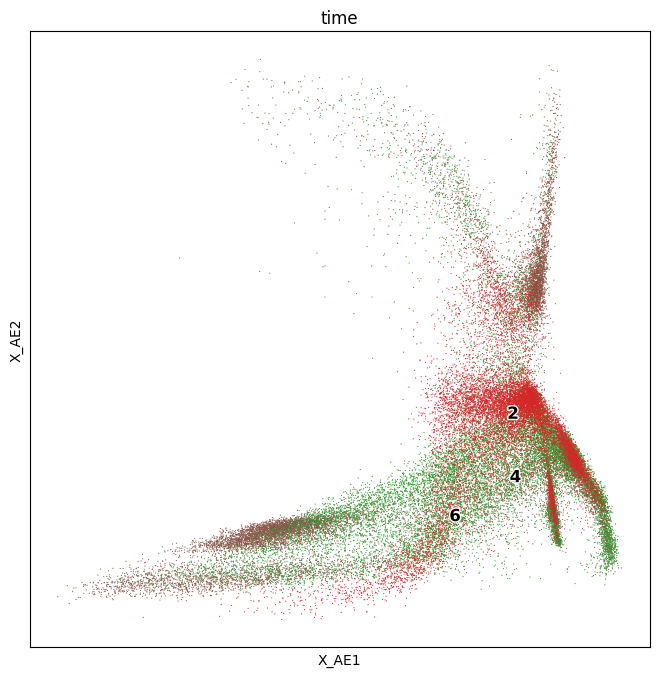

In [7]:
#######
seed=42
n_layers = 1
batch_size=128
dataset='Mouse'

lr=1e-3
n_hidden=300
n_latent = 2

path_to_data = "C:/Users/JTliu/Desktop/DiffusionOT-main/Rawdata/"

model,trainer, adata,folder=main(dataset=dataset,seed=seed,
                          n_layers=n_layers,n_latent=n_latent,n_hidden=n_hidden,
                          activation='relu',
                          lr=lr,batch_size=batch_size,
                          max_epoch=500,
                          mode='training',#mode='training','loading'
                          path_to_data = path_to_data)

model=model.to('cpu')
adata.obs['time'] = adata.obs['time'].astype(str)
generate_plots(folder,model,adata,seed,n_neighbors=20,min_dist=0.5,plots='embedding',name='time')

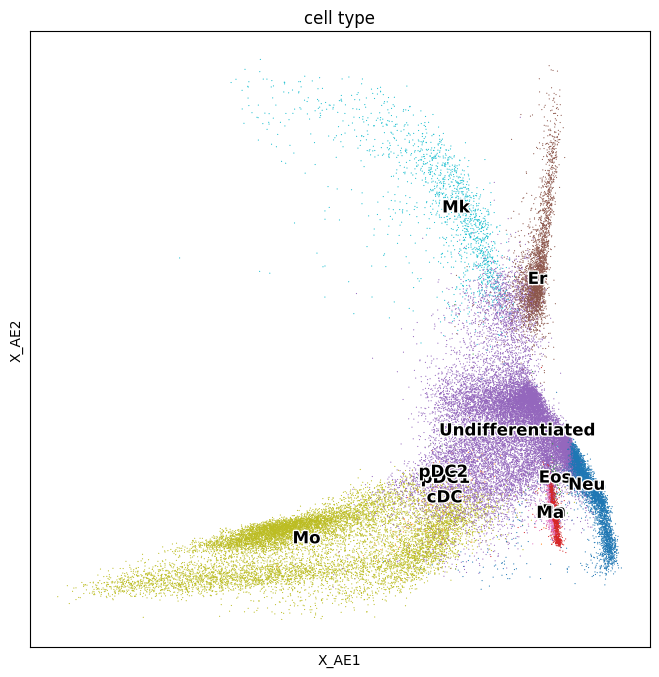

In [8]:
generate_plots(folder,model,adata,seed,n_neighbors=20,min_dist=0.5,plots='embedding',name='cell type')

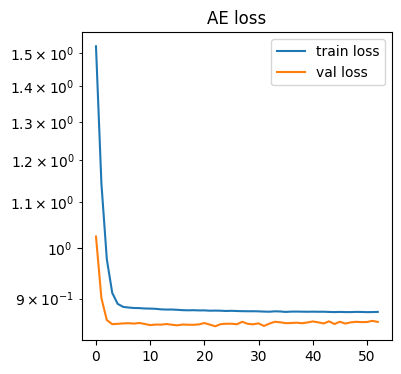

In [9]:
loss_plots(folder,model)

Normalize and Convert latent spaces data to the desired format

In [10]:
model.eval()
with torch.no_grad():
    X_latent_AE=model.get_latent_representation(torch.tensor(adata.X).type(torch.float32).to('cpu'))
adata.obsm['X_AE']=X_latent_AE.detach().cpu().numpy()
np.max(X_latent_AE.detach().cpu().numpy(),axis=0)
np.min(X_latent_AE.detach().cpu().numpy(),axis=0)
time_label = adata.obs['time'].to_numpy(dtype=object) 
type_label = adata.obs['cell type'].to_numpy(dtype=object)  
X_latent_AE_np = X_latent_AE.detach().cpu().numpy() 
# Convert points_all to the desired format
np.savez("C:/Users/JTliu/Desktop/DiffusionOT-main/Input/Mouse_latent_ae_scaled.npz",
         latent_ae_scaled=X_latent_AE_np,
         time_label=time_label,
         type_label=type_label)

## Visualization

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append('C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\')
from utility import *
args = create_args()

Name of the data set. Options: EMT; Mouse; Zebrafish; Spatial; MISA (default: MISA):  Mouse
Time points of data (default: 0,1,2,6):  0,1,2
Number of training iterations (default: 5000):  
Learning rate (default: 3e-3):  
Number of sampling points per epoch (default: 100):  
Dimension of the hidden layer (default: 16):  
Number of hidden layers (default: 4):  
Activation function (default: Tanh):  
GPU device index (default: 0):  
Input Files Directory (default: Input/):  C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Input
Output Files Directory (default: Output/):  C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Output
Random seed (default: 1):  
Diffusion coefficient (default: 0.001):  


## Load data and model

In [2]:
save_dir=args.save_dir
random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cpu')
# load dataset
data = np.load(args.input_dir+'/Mouse_latent_ae_scaled.npz', allow_pickle=True)
latent_ae_scaled = data['latent_ae_scaled']
time_label = data['time_label']
type_label = data['type_label']
time_all = ['2','4','6']
data_train = []
data_type = []
for k in range(len(time_all)):
    indices = [i for i, l in enumerate(time_label) if l == time_all[k]]
    samples = latent_ae_scaled[indices,]
    cell_type = type_label[indices,]
    samples = torch.from_numpy(samples).type(torch.float32).to(device)
    data_train.append(samples)
    data_type.append(cell_type)  
    
#data_train = loaddata(args,device)
integral_time = args.timepoints
time_pts = range(len(data_train))
leave_1_out = []
train_time = [x for i,x in enumerate(time_pts) if i!=leave_1_out]

# model
func = RUOT(in_out_dim=data_train[0].shape[1], hidden_dim=args.hidden_dim,n_hiddens=args.n_hiddens,activation=args.activation,d =args.d).to(device)
# load trained networks
if args.save_dir is not None:
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    ckpt_path = os.path.join(args.save_dir, 'ckpt_Mouse.pth')#'ckpt6_MISA3_D_{:.3f}.pth'.format(D0) 'ckpt6_MISA4.pth''ckpt_EMT.pth'ckpt_Simulation_itr2000_D_0.040
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path,map_location=torch.device('cpu'))
        func.load_state_dict(checkpoint['func_state_dict'])
        print('Loaded ckpt from {}'.format(ckpt_path))

D_t=diffusion_fit(func,args,data_train,train_time,integral_time,device,time_tt=0.1)
D=torch.mean(D_t)
func.d=torch.nn.Parameter(D)

Loaded ckpt from C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Output\ckpt_Mouse.pth


## Cell velocity

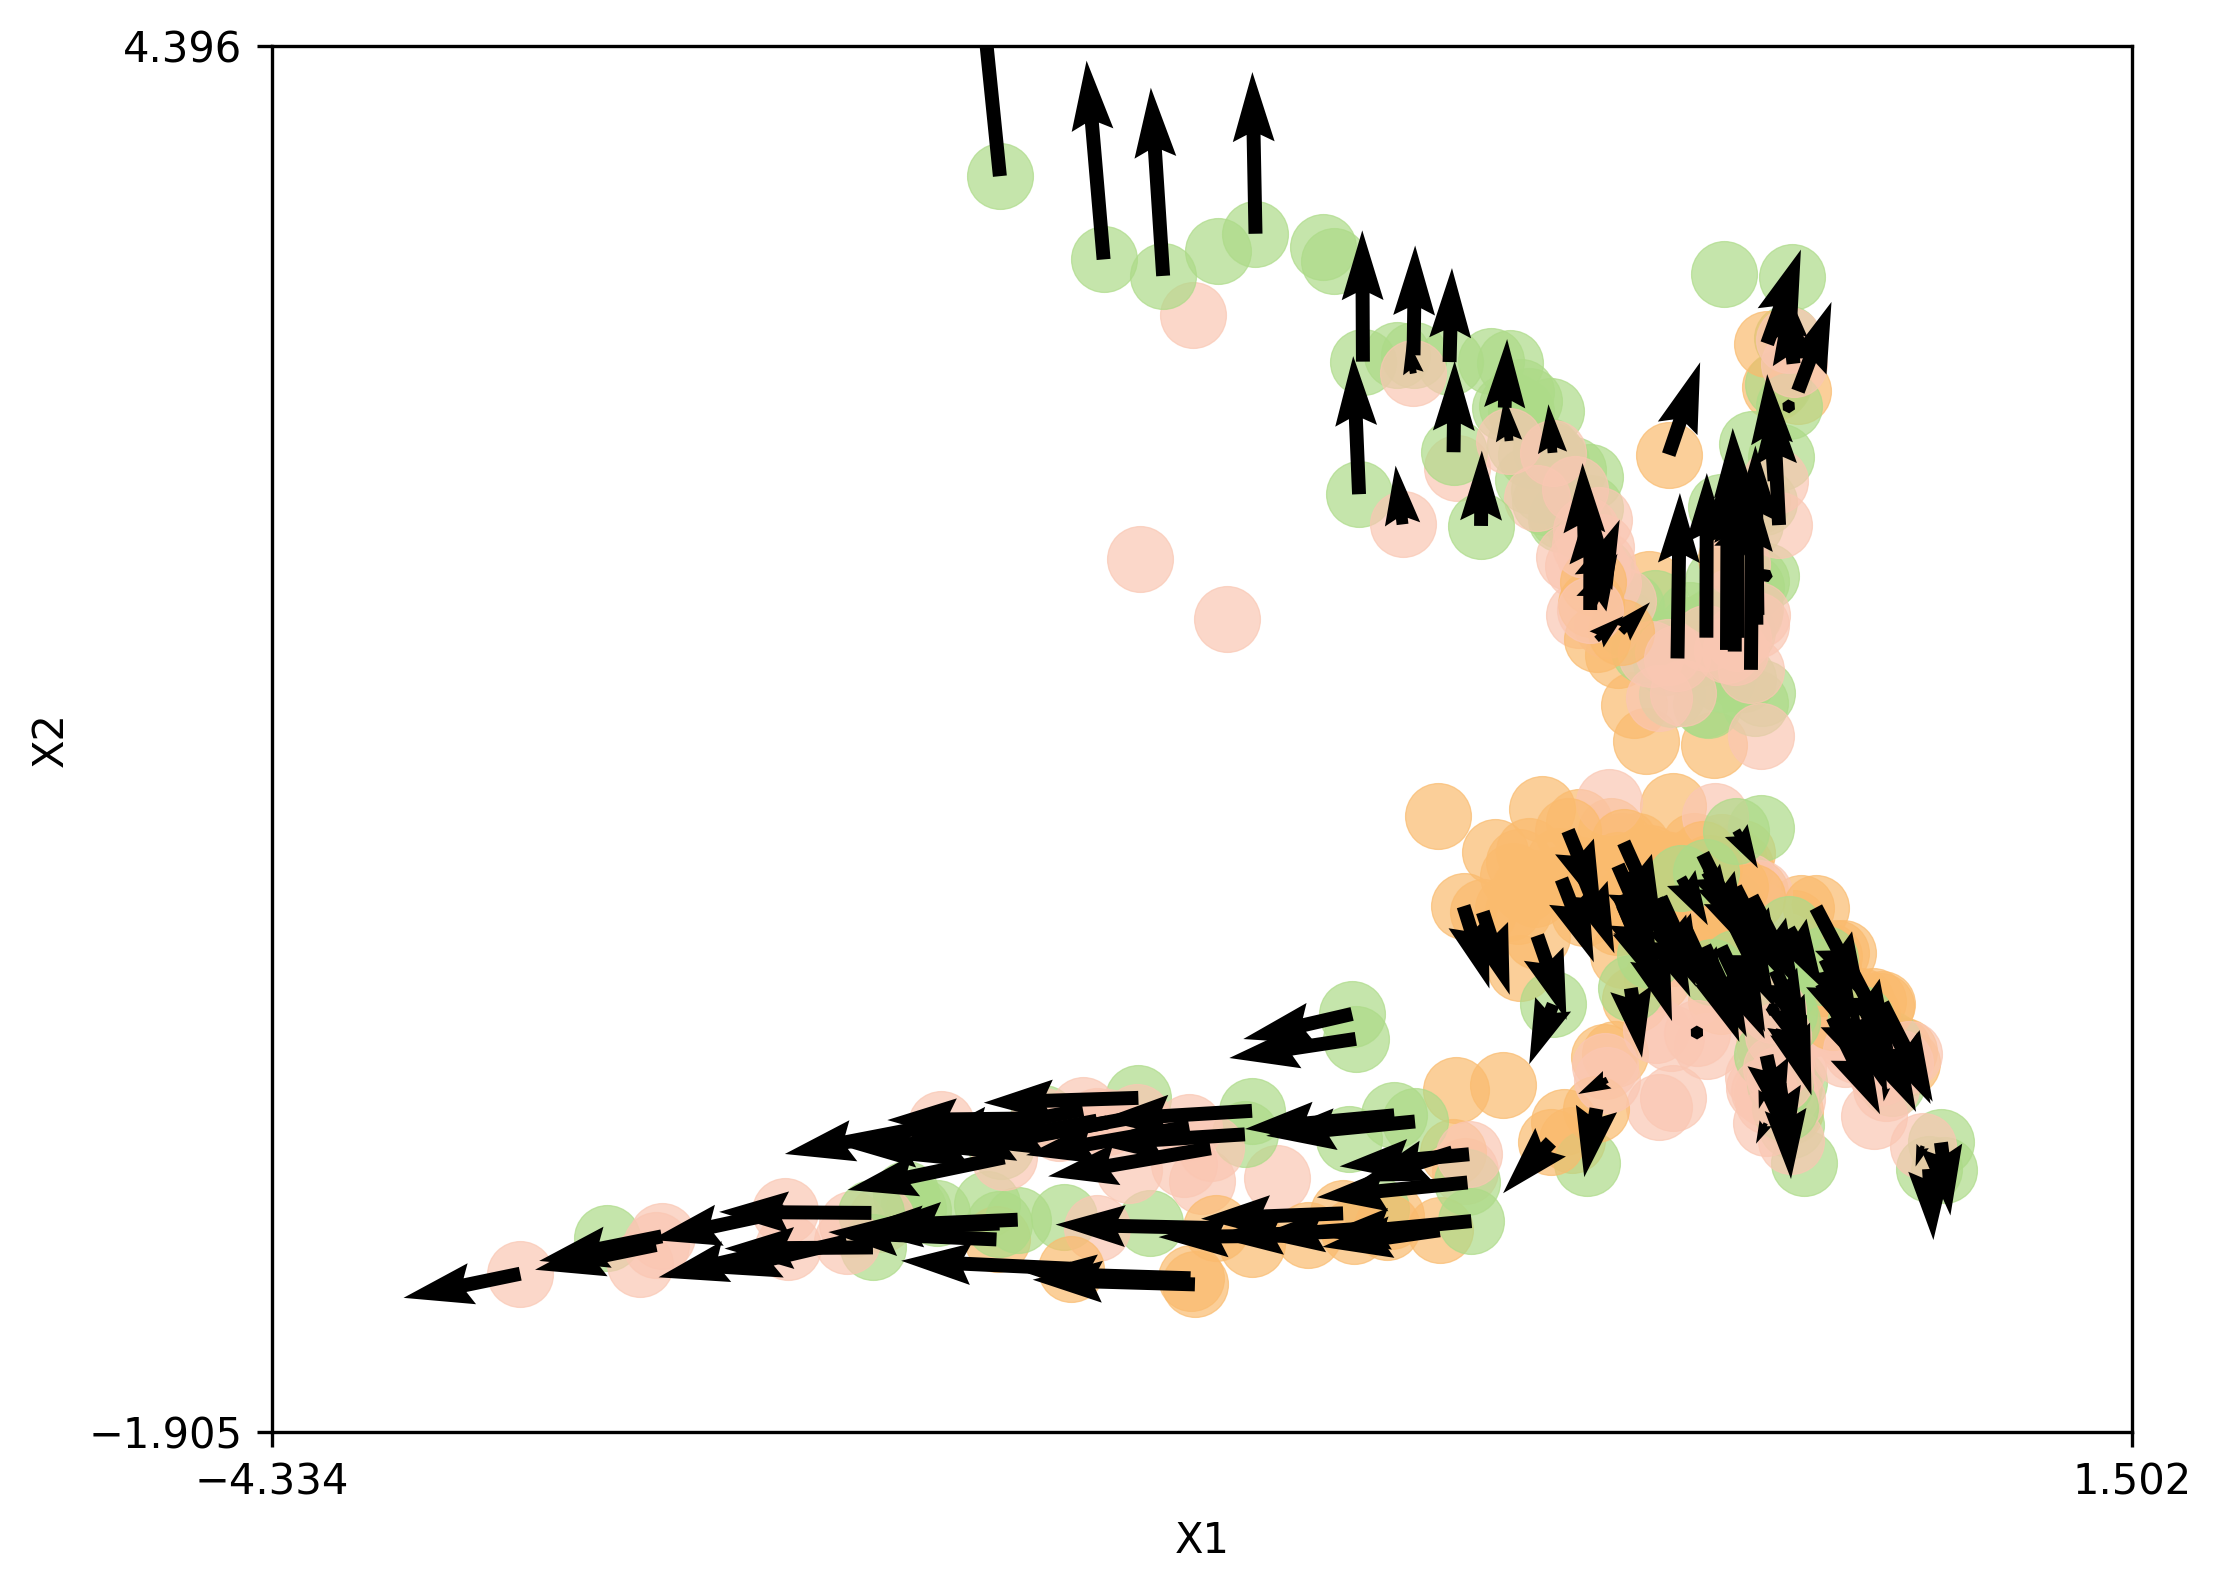

In [3]:
plot_2d_v(func,data_train,train_time,integral_time,args,device)  

## Cell fate landscape

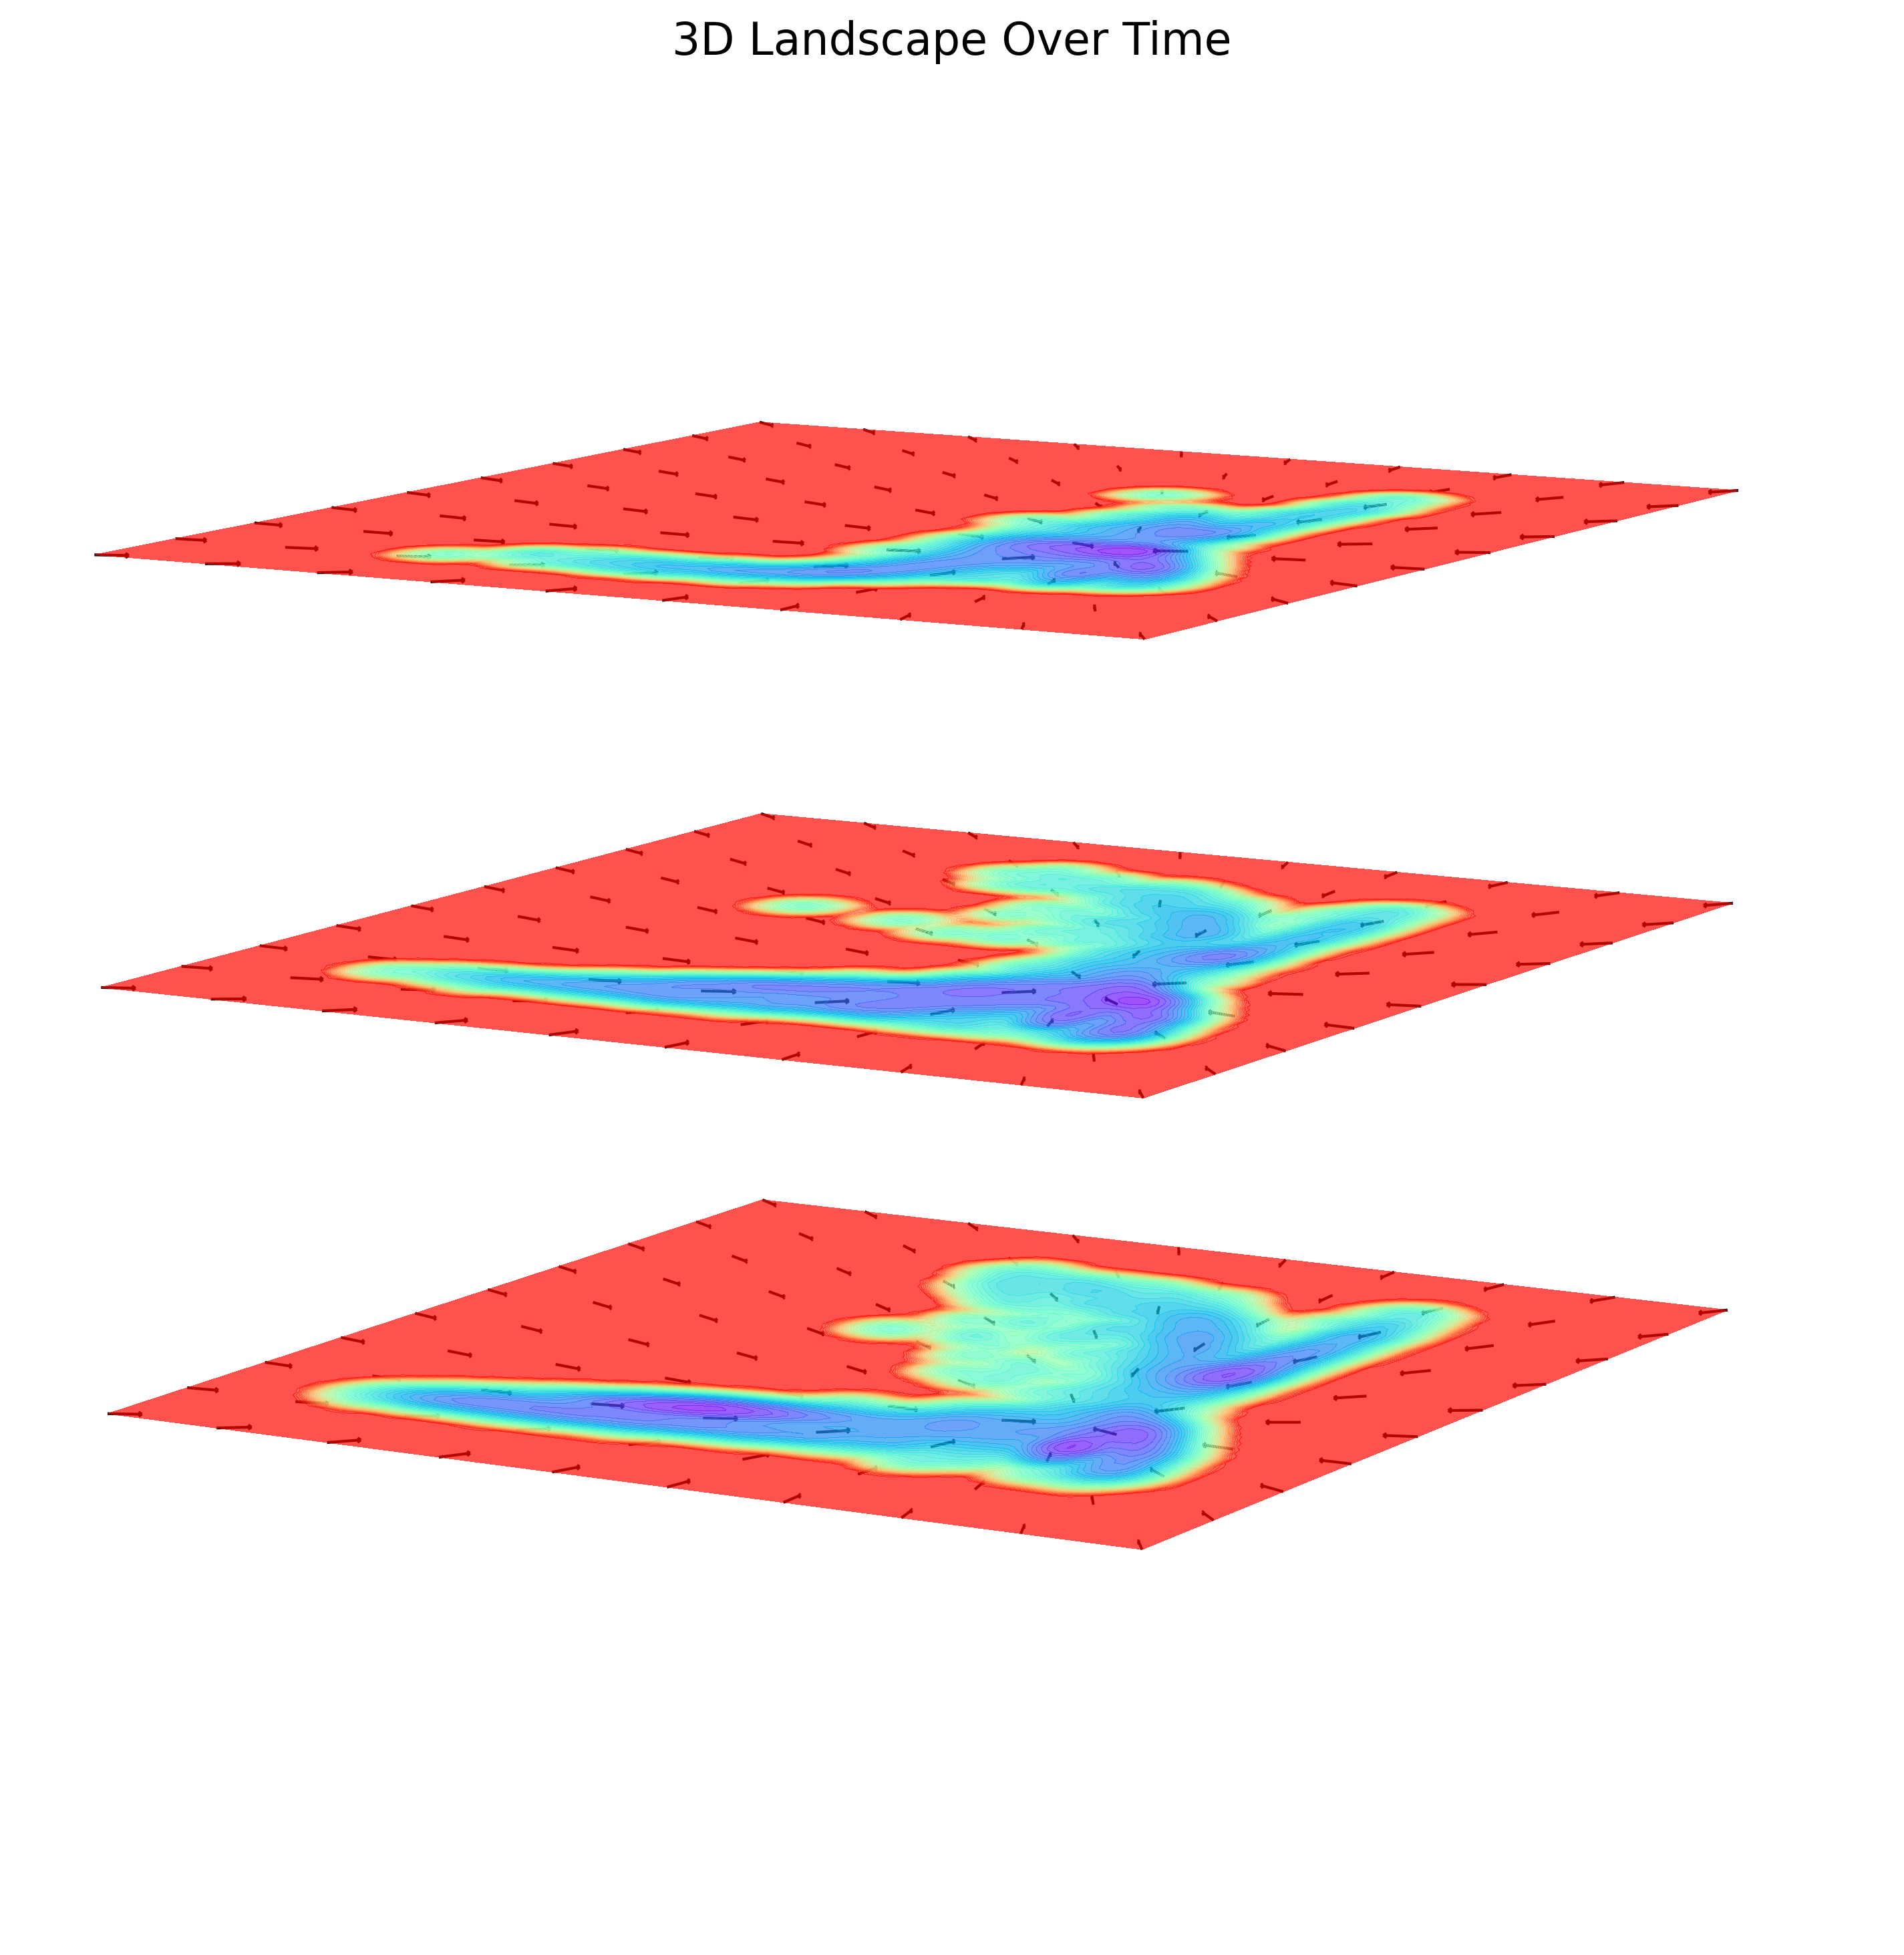

In [4]:
plot_3d_landscape(func,data_train,train_time,integral_time,args,device)

## Plot trajectory and growth

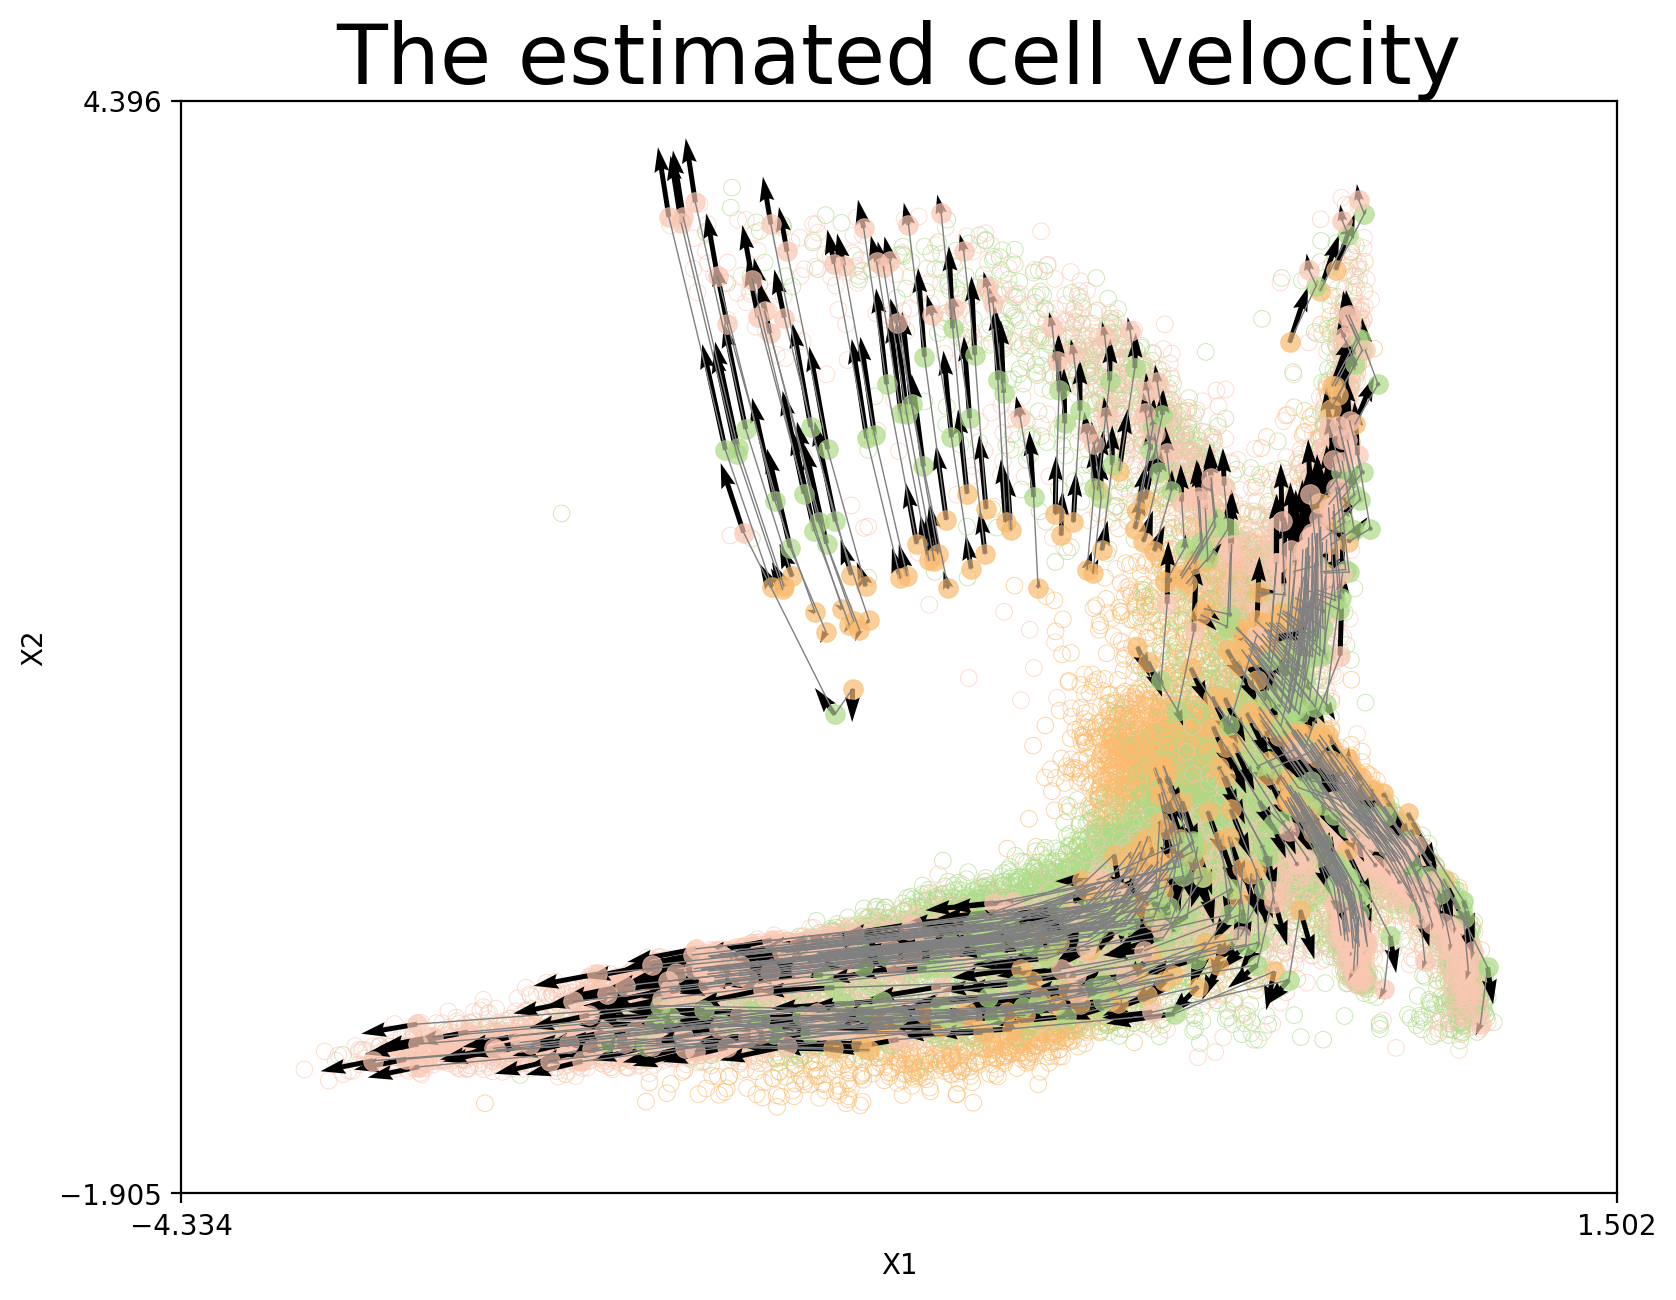

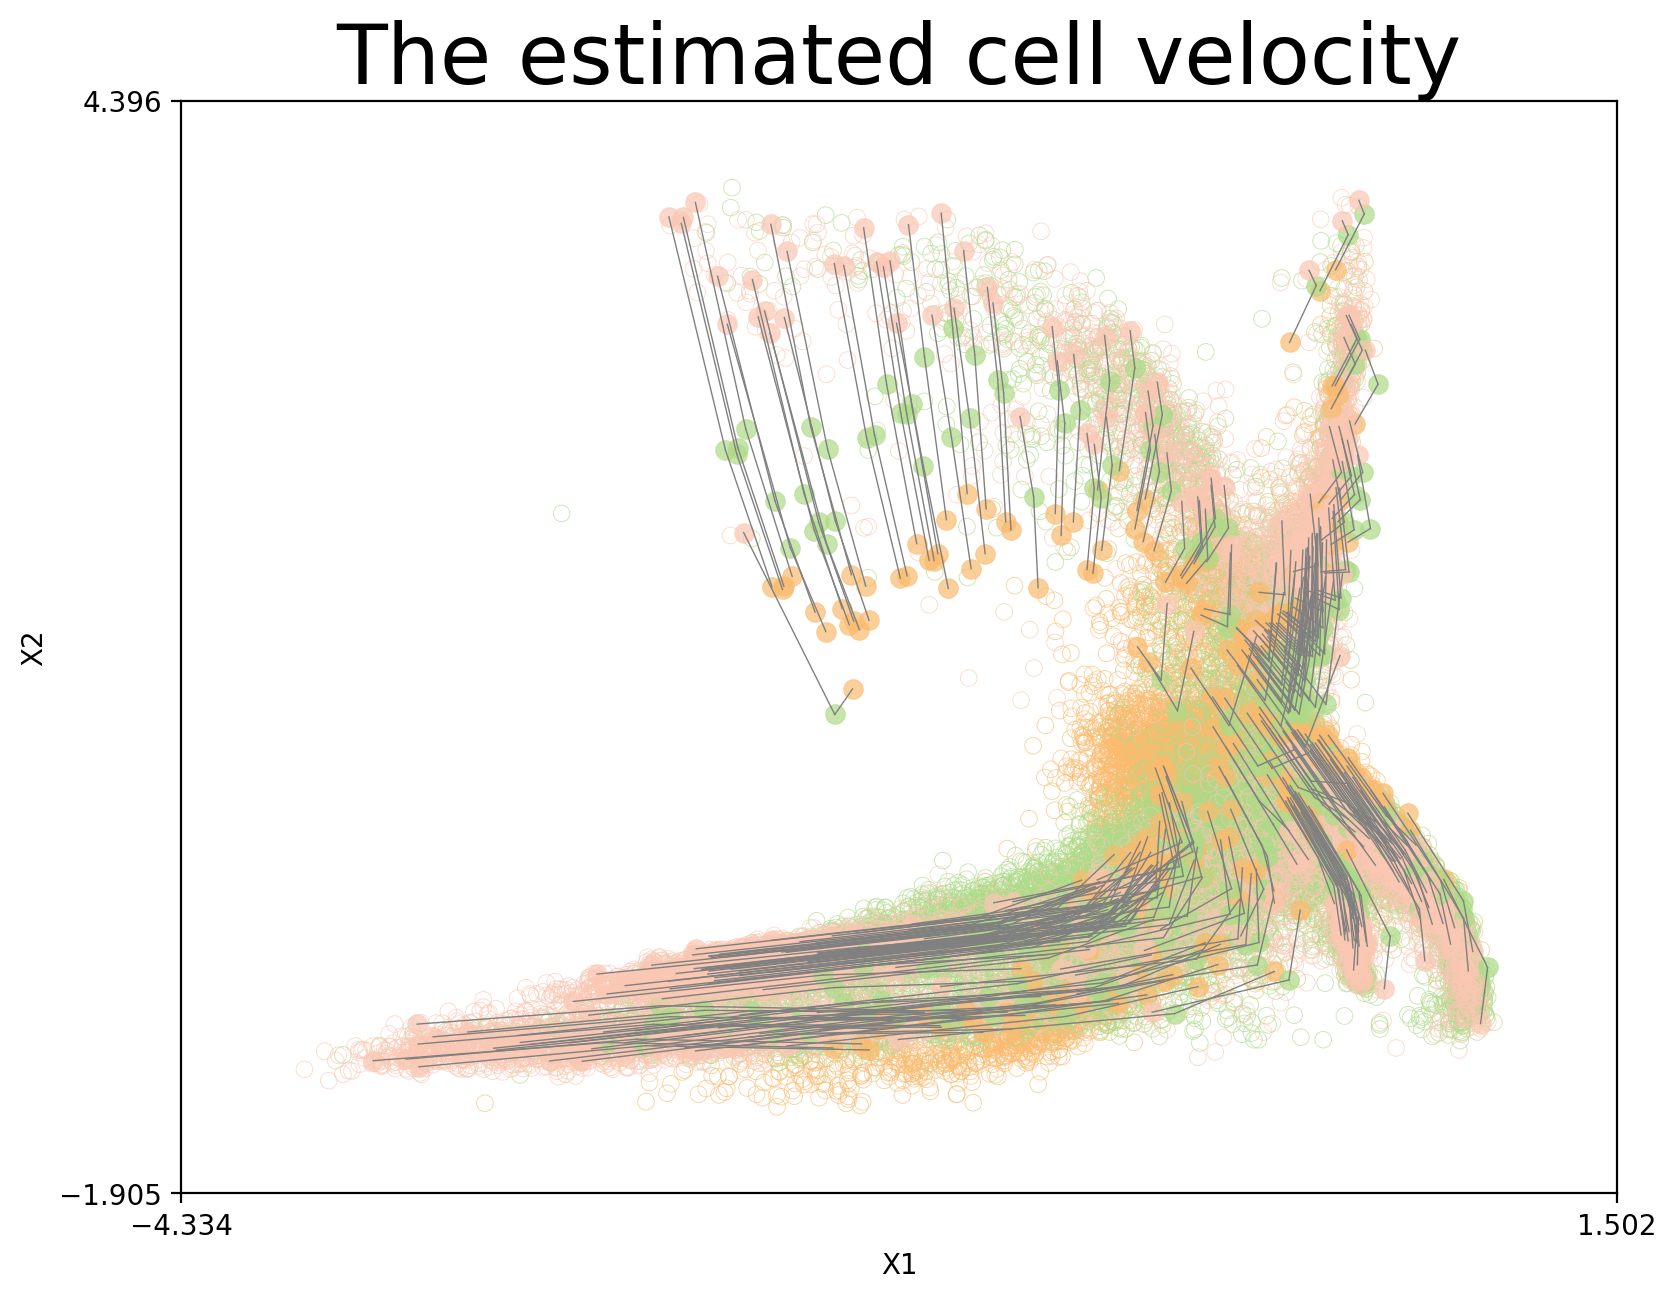

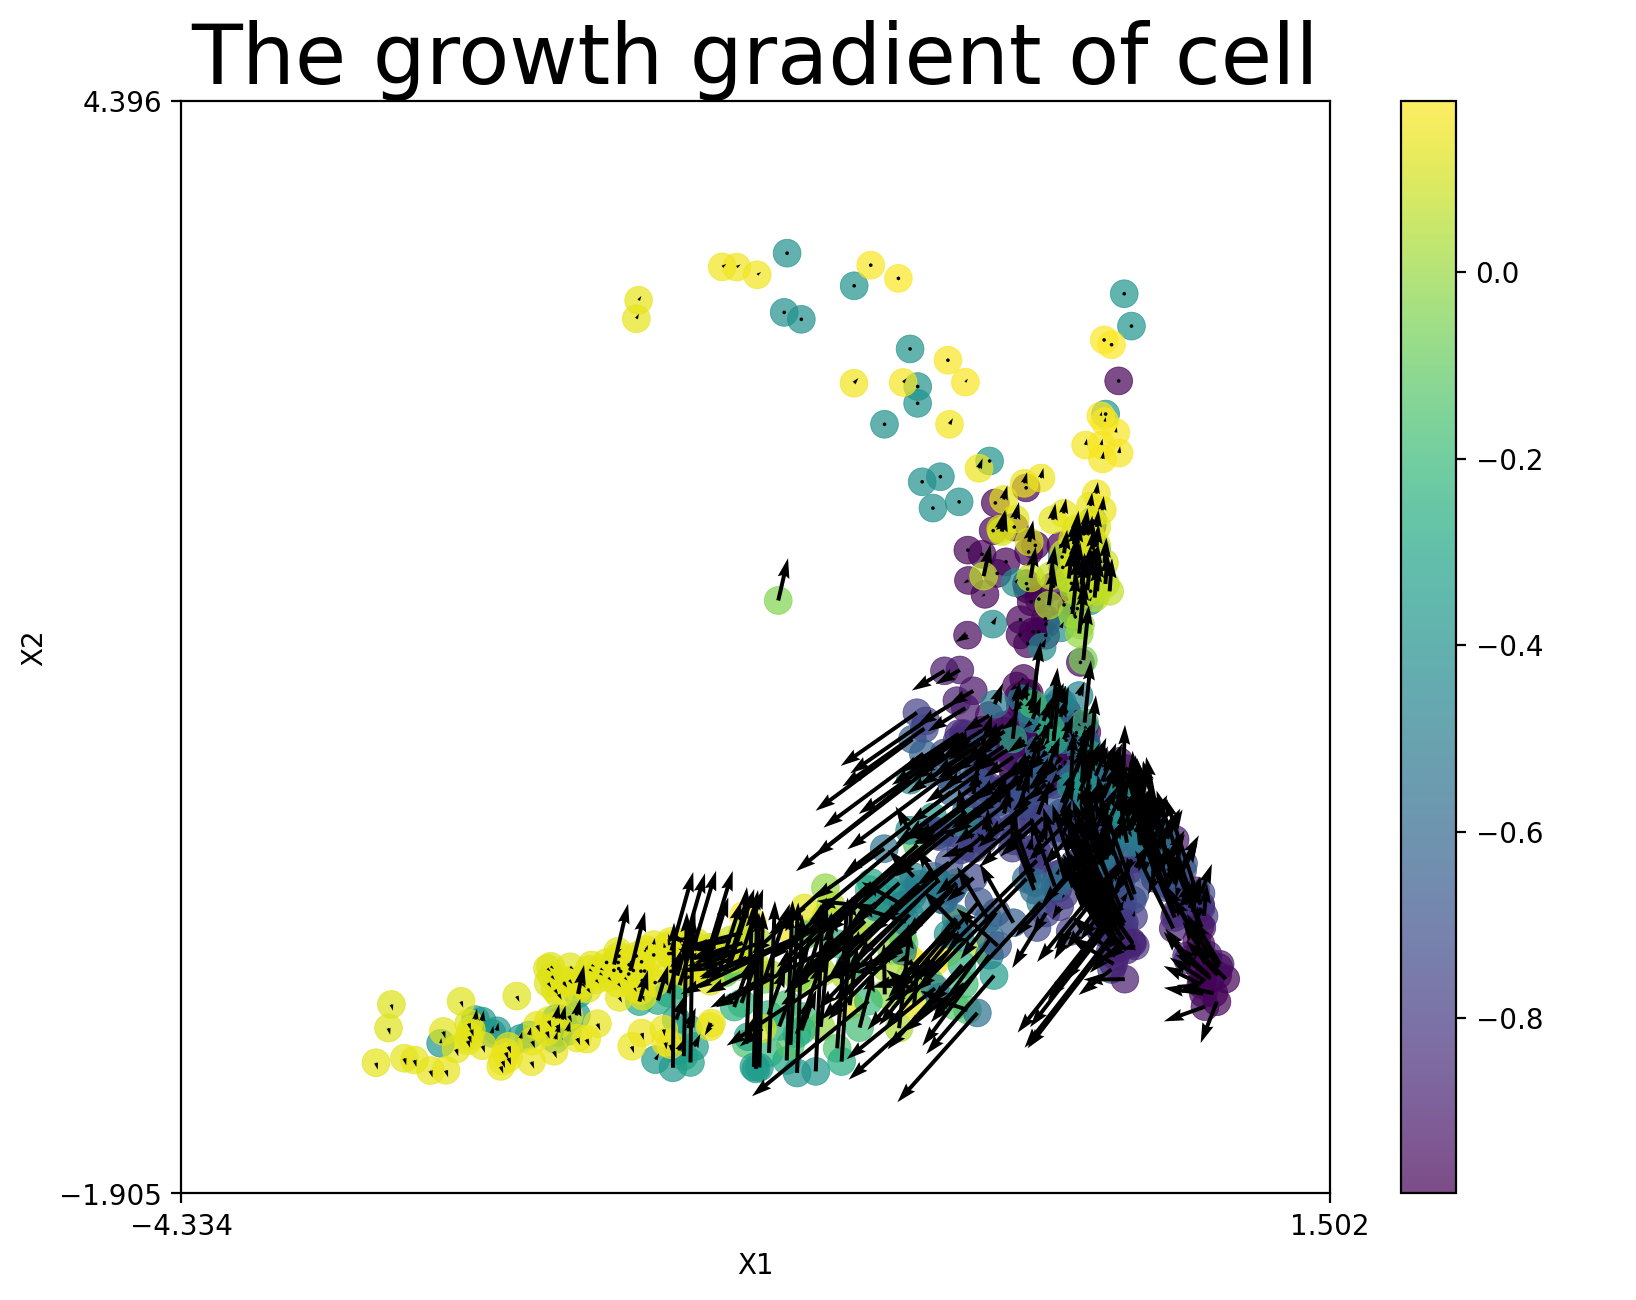

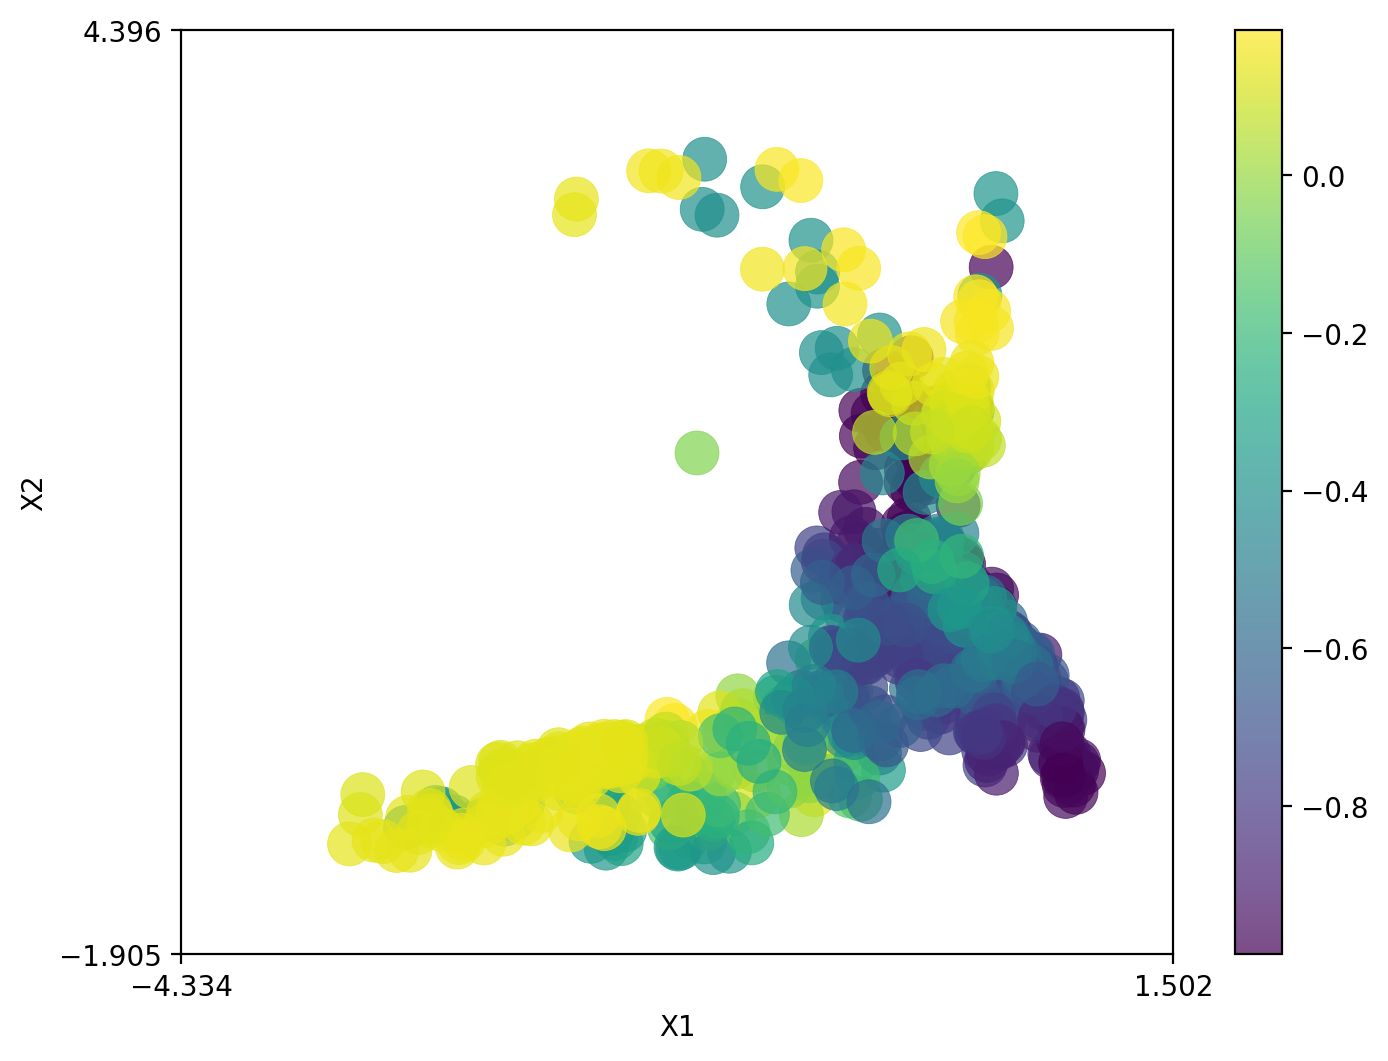

In [6]:
plot_2d(func,data_train,train_time,integral_time,args,device)  